# INM706 Deep Learning for Sequence Analysis
### Sarah Rhalem (190051884) & Stelios Kliafas (200041011)

### Import Modules & Packages

Draft Notes/ Working comments:
Dataset >> Problem +Evaluation Metric >> Model

In [1]:
#!pip install transformers

In [2]:
import os
import json
import torch
import re
import numpy as np
import pandas as pd
import csv
import random
import time
import random
import torch.nn as nn
import pickle
import warnings
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.ticker import MaxNLocator
from torch.utils.data import Dataset, DataLoader, random_split, SequentialSampler, RandomSampler
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification, BertConfig
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.translate.nist_score import corpus_nist
warnings.simplefilter("ignore", UserWarning)

from modules.bert_dataset import *
from modules.bert_train_valid import *
from modules.generate_modules import *
from modules.gpt2_netflix_dataset import *
from modules.gpt2_train_valid import *
from modules.split_datasets_and_create_dataloaders import *
from modules.utils import *


In [3]:
# Set to use GPU on device if available:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# Working directory
os.getcwd()

'C:\\Users\\public2\\Desktop\\INM706_DL_Sequence_Analysis'

### Loading & Structuring Data

In [5]:
# Load csv dataset, create listing column
raw_dataset_df= pd.read_csv(os.path.join("Data\\netflix_titles.csv") , encoding="utf8")
raw_dataset_df["listing"]= raw_dataset_df["listed_in"].str.split(pat=",", n=1).str.get(0)

# Cleanse Data
raw_dataset_df["description"].isna().sum() # Check null entries for description - None
raw_dataset_df["plot_description"]=raw_dataset_df["description"].map(lambda x: re.sub( r'"', '', x)) #remove quotation marks

# Print example of plot description
raw_dataset_df["description"].to_list()[0]

'In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.'

In [34]:
# Need to fix this 


# # Exploratory Data Analysis for the Netflix Plot Dataset
# # Maximum length of plot description is < 45 words. Max length of generation will be set to ~50 
# raw_dataset_df['Number_of_words'] = raw_dataset_df.description.apply(lambda x: len(str(x).split(' ')))
# x=raw_dataset_df['Number_of_words']
# plt.hist(raw_dataset_df['Number_of_words'])
# plt.title("Plot samples by number of words", fontsize=11)
# plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
# plt.text(x.mean() ,2500 ,'average',rotation=90)
# plt.xlabel('Number of Words')
# plt.ylabel('Number of Plot Samples')
# #plt.savefig(os.path.join(path, r'XXXXXXX.jpg'), dpi=300, bbox_inches='tight')
# plt.show()


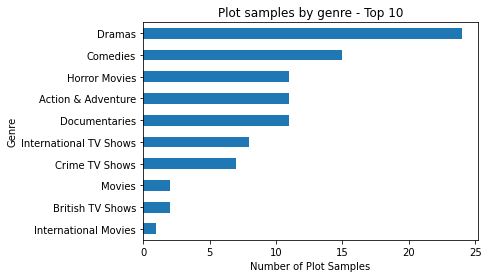

In [7]:
# Plots by genre (top 10) - will map all genres to top 10 genres
#genre_count= raw_dataset_df['listing'].value_counts()
raw_dataset_df.listing.value_counts()[:10].sort_values().plot(kind = 'barh')
plt.title("Plot samples by genre - Top 10")
plt.xlabel("Number of Plot Samples")
plt.ylabel('Genre')
plt.show()

In [8]:
# Map each data sample listing to a generic genre
# Identify the show listings for mapping to summarised genres
raw_dataset_df.listing.value_counts()

# map show listing to a specific genre. Note: Listing types with under ~100 data samples are classified under the genre "Other"
genre_mapping= { "romance": {"Romantic TV Shows", "Romantic Movies"} ,
                "drama": {"Dramas", "TV Dramas"}  ,
                 "comedy": {"Comedies", "Stand-Up Comedy", "TV Comedies", "Stand-Up Comedy & Talk Shows"},
                 "documentary": {"Documentaries", "Docuseries"},
                 "action": {"Action & Adventure", "TV Action & Adventure"} ,
                 "international": {"International TV Shows", "International Movies", "Spanish-Language TV Shows"},
                 "children": {"Children & Family Movies", "Kids' TV"},
                 "crime": {"Crime TV Shows"},
                 "horror": {"Horror Movies", "TV Horror"} ,
                 "anime" : {"Anime Series", "Anime Features"},
                 "other" : {"Thrillers", "British TV Shows", "Reality TV", "Classic & Cult TV", "TV Shows", "TV Sci-Fi & Fantasy",
                         "Classic Movies", "Movies", "Independent Movies", "Cult Movies", "Sports Movies", "LGBTQ Movies", "Music & Musicals",
                         "Sci-Fi & Fantasy"} }

# Add genre column based on listing mapping
raw_dataset_df["genre"] = raw_dataset_df["listing"].map(map_function(genre_mapping))

# Write to txt file
plot_dataset_df= raw_dataset_df[["genre","plot_description"]].copy()
plot_dataset= plot_dataset_df.to_csv('Data\\netflix_plot_dataset.txt', index=False, header=None, sep=":", doublequote=False )

# Sense check - view data header and check all descriptions were mapped
print(plot_dataset_df.head())
print(plot_dataset_df.genre.unique())

           genre                                   plot_description
0  international  In a future where the elite inhabit an island ...
1          drama  After a devastating earthquake hits Mexico Cit...
2         horror  When an army recruit is found dead, his fellow...
3         action  In a postapocalyptic world, rag-doll robots hi...
4          drama  A brilliant group of students become card-coun...
['international' 'drama' 'horror' 'action' 'crime' 'documentary' 'other'
 'comedy' 'anime']


### GPT-2 Model - Tokenizer and Configuration

In [9]:
# Load Tokenizer and config 
configuration = GPT2Config.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set pad token to eos token. Padding for GPT-2 occurs on the right so will be set to eos token.
configuration.pad_token_id = configuration.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

# Define special tokens to be used
special_tokens_dict = {
                "bos_token": "<genre>",
                 "sep_token":"<plot>",
                 "unk_token": "<unknown>"
            }
# Add special tokens 
num_of_toks= tokenizer.add_special_tokens(special_tokens_dict)
print('We have added', num_of_toks, 'tokens')


We have added 2 tokens


In [10]:
# Instantiate dataset and return length
dataset=NetflixPlotDataset(tokenizer)
dataset.__len__()

99

In [11]:
# Example of decoded tokenizer plot sample from the dataset.
tokenizer.decode(dataset[23])

'<genre> drama : <plot> When a middle-aged divorcee returns to Kolkata to visit his ailing father, long-buried memories resurface, bringing new discoveries with them.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

## Fine-tuning GPT-2 

### Training & Validation

In [12]:
# load Dataloaders
dataloaders = split_datasets_and_create_dataloaders(dataset, batch_size=10)

Number of Training samples: 69
Number of Validation samples: 19
Number of Testing samples: 11


In [13]:
# Re-Instantiate model and corresponding config file, reapply resizing for token embeddings
# Re-run before train_val method is called to ensure that the pretrained model is not being updated after every train call during hyperparameter tuning
configuration = GPT2Config.from_pretrained('gpt2')
configuration.pad_token_id = configuration.eos_token_id

model= GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model= model.to(device)
model.resize_token_embeddings(len(tokenizer)) # resize token embeddings as model is instantiated

#Hyperparameters
EPOCHS=4  
TRAIN_STEPS= len(dataloaders['train_dataloader'])*EPOCHS
WU_RATE= 0.2
WU_STEPS= TRAIN_STEPS * WU_RATE# Warm up rate of ~0.2% 
OPTIM= AdamW(model.parameters(), lr = 3e-5,eps = 1e-8, weight_decay=0.01)
SCHEDULER= get_linear_schedule_with_warmup(optimizer=OPTIM, num_warmup_steps =WU_STEPS, num_training_steps =TRAIN_STEPS)


In [14]:
# Run train_val
Test_1= gpt2_train_val(model, dataloaders, tokenizer, starting_epoch=0, optimizer=OPTIM, scheduler=SCHEDULER, epochs=EPOCHS, device=device)




---------------
| TRAINING... |
---------------



 epoch: 1, train loss: 77.861501, train ppl: 6528619706562334930016678652674048.000000, train time:00:07:14
Validating...



 epoch: 1, val loss: 51.846729, val ppl: 32866119410845086646272.000000, val_time: 00:00:01

Training Finished



 epoch: 2, train loss: 17.893262, train ppl: 59012680.000000, train time:00:08:47
Validating...



 epoch: 2, val loss: 8.425192, val ppl: 4560.519531, val_time: 00:00:00

Training Finished



 epoch: 3, train loss: 7.190811, train ppl: 1327.179321, train time:00:09:39
Validating...



 epoch: 3, val loss: 5.465960, val ppl: 236.502686, val_time: 00:00:00

Training Finished



 epoch: 4, train loss: 5.702821, train ppl: 299.711639, train time:00:10:27
Validating...



 epoch: 4, val loss: 4.665784, val ppl: 106.248840, val_time: 00:00:00

Training Finished


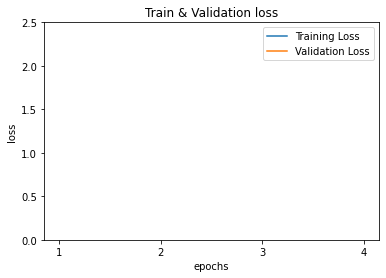

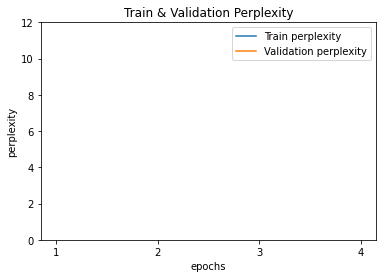

In [15]:
# Display Train & Validation loss and perplexity plots

fig= plot_train_val_loss(Test_1, "Train & Validation loss");
#fig.savefig(r'Figures\\train_val_loss_4eps_crop.jpg')

fig= plot_train_val_perplexity(Test_1, "Train & Validation Perplexity");
#fig.savefig(r'Figures\\train_val_perplexity_4eps_crop.jpg')

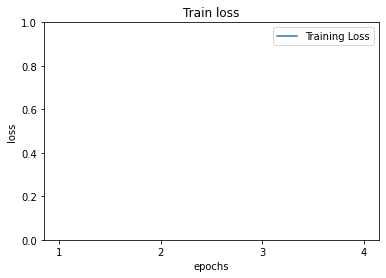

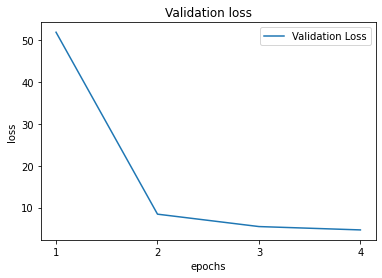

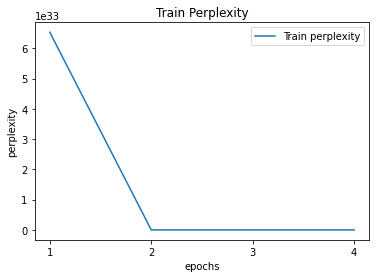

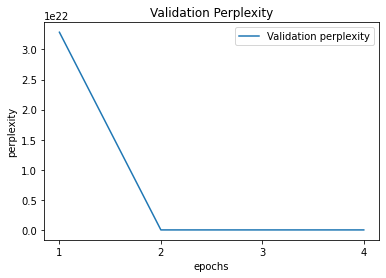

In [16]:
# Plot train/val loss and perplexity
fig= plot_train_loss(Test_1, "Train loss");
#fig.savefig(r'Figures\\train_loss_4eps.jpg')

fig= plot_val_loss(Test_1, "Validation loss");
#fig.savefig(r'Figures\\val_loss_4eps.jpg')

fig= plot_train_perplexity(Test_1, "Train Perplexity");
#fig.savefig(r'Figures\\train_perplexity_4eps.jpg')

fig= plot_val_perplexity(Test_1, "Validation Perplexity");
#fig.savefig(r'Figures\\val_perplexity_4eps.jpg')


In [17]:
Test_1

{'train_loss': [77.86150087629046,
  17.89326204572405,
  7.190811089106968,
  5.702820709773472],
 'val_loss': [51.84672927856445,
  8.42519211769104,
  5.465959787368774,
  4.665783643722534],
 'train_perplexity': [tensor(6.5286e+33),
  tensor(59012680.),
  tensor(1327.1793),
  tensor(299.7116)],
 'val_perplexity': [tensor(3.2866e+22),
  tensor(4560.5195),
  tensor(236.5027),
  tensor(106.2488)]}

## Evaluating fine-tuned GPT-2 model 

### Testing and generating plots

In [18]:
# Instantiate model, apply resizing for token embeddings - re-run instantiation before training
configuration = GPT2Config.from_pretrained('gpt2')
configuration.pad_token_id = configuration.eos_token_id

model= GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model= model.to(device)
model.resize_token_embeddings(len(tokenizer))

dataloaders = split_datasets_and_create_dataloaders(dataset, batch_size=10)

EPOCHS=10
TRAIN_STEPS= len(dataloaders['train_dataloader'])*EPOCHS
WU_RATE= 0.2
WU_STEPS= TRAIN_STEPS * WU_RATE# Warm up rate of ~0.2% 
OPTIM= AdamW(model.parameters(), lr = 3e-5,eps = 1e-8, weight_decay=0.01)
SCHEDULER= get_linear_schedule_with_warmup(optimizer=OPTIM, num_warmup_steps =WU_STEPS, num_training_steps =TRAIN_STEPS)


#load_checkpoint(model, optimizer=OPTIM, scheduler=SCHEDULER, load_checkpoint_path= "checkpoint_4.pth.tar")

Number of Training samples: 69
Number of Validation samples: 19
Number of Testing samples: 11


In [19]:
test_run= test_generate(model, tokenizer, dataloaders, device)


test loss: 93.939968, test ppl: inf, bleu score default:0.09178928469406582, bleu score modified 1: 0.14867098141643395, bleu score modified 2: 0.17940884281852873


In [20]:
# Generate 20 plot samples for human analysis and evaluation
set_seed()
test_samples= generate_text(model, tokenizer, device, num_samples=20) 
plot_samples_csv(test_samples, "results/generated_plots_10.csv")

print(*test_samples, sep="\n")


anime: In the n a m e p O C Q R S T U V W A w 2 3
romance: world is a world is a place in the region where there had been had been or that was so as
children: that the that you, you and and I I the of of my on my on me me ( )
crime: I in in for a an that $ as I a an $ and
 the my "
anime: Fm
 Fr a a r " I A P S A E E I
 G G M
romance: one which it is a one that the that the it, and I my about, about I my to
documentary: individual individual person has been a member of the House of the House has been a member who is an person
crime: S for its the character of the s, and as it is an l, that I am s,
crime: of the and all of the and all for, it is a for, it is a if I in
action: country could be used as a basis for the discussion of on in about which said I do am not sure
other: person was a ( " " ),,,, ( ); ;. _. _
 the of
comedy: " ". }.. The I , It The I It
 {... the H G {
romance: first one
 to and I,.; And the first,. In " ( -- ) 11 12
horror: the the The I - The I - There it -- – But

In [21]:
# Load results from test runs for models trained on 4, 5, 10 and 15 epochs.

test_results_4eps=load_test_results("Results/test_results_4eps.pickle")
test_results_5eps=load_test_results("Results/test_results_5eps.pickle")
test_results_10eps=load_test_results("Results/test_results_10eps.pickle")
test_results_15eps=load_test_results("Results/test_results_15eps.pickle")

print("test_results_4eps:", test_results_4eps)

print("test_results_5eps:", test_results_5eps)

print("test_results_10eps:", test_results_10eps)

print("test_results_15eps:", test_results_15eps)

test_results_4eps: {'mean_test_loss': 2.2205523558152027, 'mean_test_perplexity': tensor(9.2124), 'bleu_score_default': 0.2656229884281992, 'bleu_score_modified1': 0.4615032366702634, 'bleu_score_modified2': 0.5757460040325079}
test_results_5eps: {'mean_test_loss': 2.232163253502968, 'mean_test_perplexity': tensor(9.3200), 'bleu_score_default': 0.26352389174391366, 'bleu_score_modified1': 0.4582023246689671, 'bleu_score_modified2': 0.5721885943523811}
test_results_10eps: {'mean_test_loss': 2.308769724307916, 'mean_test_perplexity': tensor(10.0620), 'bleu_score_default': 0.2619485639996878, 'bleu_score_modified1': 0.45868924657359605, 'bleu_score_modified2': 0.5735864393209578}
test_results_15eps: {'mean_test_loss': 2.442454231091035, 'mean_test_perplexity': tensor(11.5012), 'bleu_score_default': 0.2618981701455584, 'bleu_score_modified1': 0.4589993107018156, 'bleu_score_modified2': 0.5738677662513724}


# GPT-2 Vanilla
### Test vanilla GPT-2 (without fine-tuning) 

In [22]:
configuration = GPT2Config.from_pretrained('gpt2')
configuration.pad_token_id = configuration.eos_token_id

model= GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model= model.to(device)
model.resize_token_embeddings(len(tokenizer))

test_vanilla= test_generate(model, tokenizer, dataloaders, device)


test loss: 90.802029, test ppl: inf, bleu score default:0.11817619355043602, bleu score modified 1: 0.1907157963047158, bleu score modified 2: 0.2306959415126402


In [23]:
# Vanilla GPT-2 generated samples example
test_samples= generate_text(model, tokenizer, device, num_samples=10) 
print(*test_samples, sep="\n")


anime: the and The my I
 more I my
 more a an some to to they me me this an
romance: person individual have become a person; the " or an a one an and the " of of,,
children: the the anchild. a an that that a n n m m l r r s st s st
crime: I a I a an an " " it it
 and the in that and in the this, of
anime: the and an of an of a a
romance: to " to " and and.; the,,,.,.;.,.;.,.-;."
documentary: ( )
 the ( ) a
 a the in in over over under if if --, and are
crime: " a " the n the e n m m e r o c u a l u b r i
crime: I the first second second and the first by and by that that of of, said is to is to
action: company, - service, - service – that to that to the it – the it and I I L


### BERT - Section

In [24]:
plot_dataset_df["genre"] = plot_dataset_df["genre"].astype('category')
plot_dataset_df["genre_codes"] = plot_dataset_df['genre'].cat.codes
plot_dataset_df.head()

,genre,plot_description,genre_codes
0,international,In a future where the elite inhabit an island ...,7
1,drama,After a devastating earthquake hits Mexico Cit...,5
2,horror,"When an army recruit is found dead, his fellow...",6
3,action,"In a postapocalyptic world, rag-doll robots hi...",0
4,drama,A brilliant group of students become card-coun...,5


In [25]:
plot_dataset_df["genre_codes"].max() # Number of label classes

8

In [26]:
labels = plot_dataset_df.genre_codes.values
movie_plots = plot_dataset_df.plot_description.values

In [27]:
config = BertConfig.from_pretrained('bert-base-cased', num_labels=plot_dataset_df["genre_codes"].max()+1)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForSequenceClassification(config)

In [28]:
bert_dataset = BertDataset(movie_plots, labels, tokenizer)
bert_dataset.__len__()

99

In [29]:
dataloaders = split_datasets_and_create_dataloaders(bert_dataset, batch_size=10)

Number of Training samples: 69
Number of Validation samples: 19
Number of Testing samples: 11


In [30]:
#Hyperparameters
EPOCHS=4  
TRAIN_STEPS= len(dataloaders['train_dataloader'])*EPOCHS
WU_RATE= 0.2
WU_STEPS= TRAIN_STEPS * WU_RATE# Warm up rate of ~0.2% 
OPTIM= AdamW(model.parameters(), lr = 3e-5,eps = 1e-8, weight_decay=0.01)
SCHEDULER= get_linear_schedule_with_warmup(optimizer=OPTIM, num_warmup_steps =WU_STEPS, num_training_steps =TRAIN_STEPS)

In [31]:
Test_bert= bert_train_val(model, dataloaders,starting_epoch=0, optimizer=OPTIM, scheduler=SCHEDULER, epochs=EPOCHS, device=device)



---------------
| TRAINING... |
---------------


Epoch:  1 / 4 Batch:  1 / 7 Loss:  2.2698121070861816 Accuracy:  0.0

 epoch: 1, train loss: 2.193900, train accuracy: 0.103175, train time:00:00:39
Validating...



 epoch: 1, val loss: 1.851920, val accuracy: 0.322222, val_time: 00:00:02

Training Finished


Epoch:  2 / 4 Batch:  1 / 7 Loss:  2.5224215984344482 Accuracy:  0.2

 epoch: 2, train loss: 2.222825, train accuracy: 0.144444, train time:00:01:22
Validating...



 epoch: 2, val loss: 2.168654, val accuracy: 0.050000, val_time: 00:00:04

Training Finished


Epoch:  3 / 4 Batch:  1 / 7 Loss:  1.9743525981903076 Accuracy:  0.1

 epoch: 3, train loss: 2.117161, train accuracy: 0.158730, train time:00:02:06
Validating...



 epoch: 3, val loss: 1.943562, val accuracy: 0.211111, val_time: 00:00:02

Training Finished


Epoch:  4 / 4 Batch:  1 / 7 Loss:  2.271639823913574 Accuracy:  0.2

 epoch: 4, train loss: 2.097076, train accuracy: 0.187302, train time:00:02:50
Validating...



 epoch: 4, val loss: 1.943560, val accuracy: 0.322222, val_time: 00:00:04

Training Finished


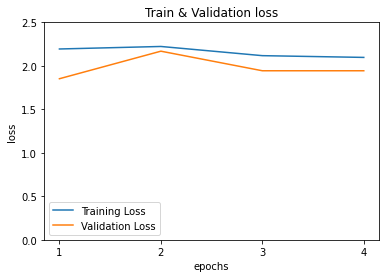

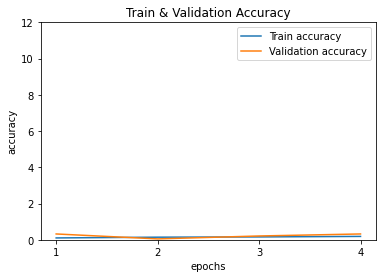

In [32]:
# Display Train & Validation loss and perplexity plots

fig= plot_train_val_loss(Test_bert, "Train & Validation loss");
#fig.savefig(r'Figures\\train_val_loss_4eps_crop.jpg')
print("")
fig= plot_train_val_accuracy(Test_bert, "Train & Validation Accuracy");
#fig.savefig(r'Figures\\train_val_perplexity_4eps_crop.jpg')

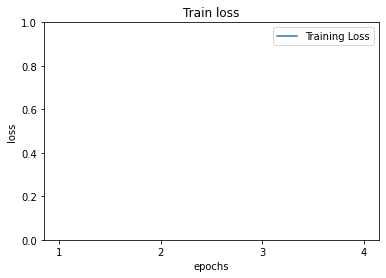

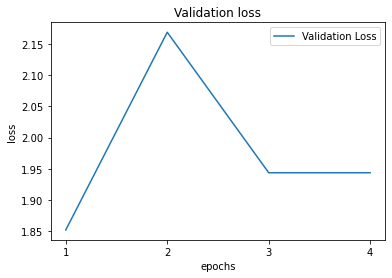

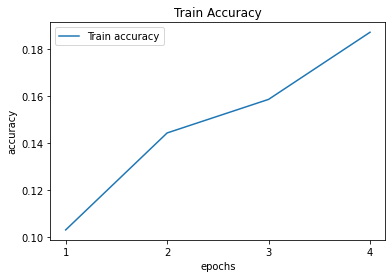

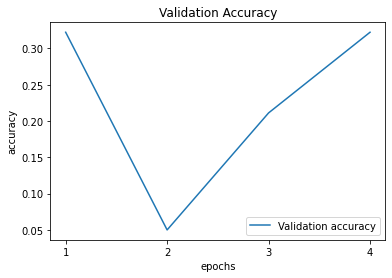

In [33]:
# Plot train/val loss and perplexity
fig= plot_train_loss(Test_bert, "Train loss");
#fig.savefig(r'Figures\\train_loss_4eps.jpg')

fig= plot_val_loss(Test_bert, "Validation loss");
#fig.savefig(r'Figures\\val_loss_4eps.jpg')

fig= plot_train_accuracy(Test_bert, "Train Accuracy");
#fig.savefig(r'Figures\\train_perplexity_4eps.jpg')

fig= plot_val_accuracy(Test_bert, "Validation Accuracy");
#fig.savefig(r'Figures\\val_perplexity_4eps.jpg')


#### IGNORE BELOW - WORKING CODE